# **Natural Language Processing Project - Twitter US Airline Sentiment**

**Context**

Businesses relying on tweets that their users post on Twitter to understand how they feel about the product/service, keep on top of what’s being said about their brand and their competitors, and discover new trends in the industry.
However, due to huge amount of active users on Twitter posting millions of tweets, its difficult for businesses to quickly detect negative social mentions that could harm their business. To understand the emotions behind the tweets has become a key strategy in social media marketing for businesses. 

As part of this project, going to work with the twitter data of major US airlines. 


**Objective**

The objective is to create a model to do sentiment analysis/classification of tweets based on the emotions in conversations on social media platforms. To achieve that, will try different techniques/models and figure out which work the best. 



**Data Discription**

For this project, twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

The dataset has the following columns:

* tweet_id                                                           
* airline_sentiment                                               
* airline_sentiment_confidence                               
* negativereason                                                   
* negativereason_confidence                                    
* airline                                                                    
* airline_sentiment_gold                                              
* name     
* negativereason_gold 
* retweet_count
* text
* tweet_coord
* tweet_created
* tweet_location 
* user_timezone

# **1. Data Summary**

Let's create data summary by downloading required packages, importing required libraries and given dataset and exploring data at high level. 

## **Install and Import Required Libraries**

In [63]:
# Importing required libraries

import re
import numpy as np                                  #for large and multi-dimensional arrays
import pandas as pd                                 #for data manipulation and analysis
import nltk                                         #Natural language processing tool-kit

nltk.download('stopwords')    #download stopwords
nltk.download('punkt')

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF

#!pip install vaderSentiment    # Install vader sentiment package
#!pip install textblob   # Install textblob package

# install and import necessary libraries.

!pip install contractions

import re, string, unicodedata                          # Import Regex, string and unicodedata.
import contractions                                     # Import contractions library.
from bs4 import BeautifulSoup                           # Import BeautifulSoup.

import numpy as np                                      # Import numpy.
import pandas as pd                                     # Import pandas.
import nltk                                             # Import Natural Language Tool-Kit.

from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.
import matplotlib.pyplot as plt   
from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns


from sklearn.ensemble import RandomForestClassifier       # Import Random forest Classifier
from sklearn.metrics import classification_report         # Import Classification report
from sklearn.model_selection import cross_val_score 
from nltk.corpus import stopwords                       # Import stopwords to remove words from text


# Importing Libraries to help with EDA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
sns.set()

# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importing Data**

The dataset is stored in google drive, so let's mount is and read the data.

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Loading Tweets file and making copy of it just in case if need to revert back
twt = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Tweets.csv')
twt_copy = twt.copy()

## **Exploring Data At High Level**

Let's explore the data. To start with let's check few records.

In [4]:
twt.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


At a first glance, data seems to have quite a few null records in different columns. Column 'text' has the tweet info and will have to analyze that and 'airline_sentiment' looks to have sentiment so that would be the target column.

Let's check few basic things to understand the dataset better. Will start with the shape of dataset.

In [5]:
# checking shape of images
twt.shape

(14640, 15)

There are 14640 rows and 15 columns.

Next, check for duplicates.

In [6]:
# checking for dups
twt.duplicated().sum()

36

There are 36 duplicates, let's keep only 1 of them. 

In [7]:
twt.drop_duplicates(keep='last',inplace=True)

Check shape one more time.

In [8]:
twt.shape

(14604, 15)

Looks good. Next, check for nulls

In [9]:
# check for null values

twt.isnull().sum(axis=0)    

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64

As we mainly interested in columns like 'airline', 'text' and 'airline_sentiment', there are no nulls in there. So it's good. Also, the null in columns like 'negativereason', 'negativereason_confidence' could be because of non-negative airline_sentiment. 

Check the different values of airline_sentiment column as that's the target column for us.

In [10]:
twt.airline_sentiment.value_counts()

negative    9159
neutral     3091
positive    2354
Name: airline_sentiment, dtype: int64

Data is divided into 3 classes. Negative, neutral and positive. It is kind of inbalanced with majority records with negative sentiments.

# **2. Exploratory Data Analysis (EDA)**

Let's create a function to plot stacked barplot to check airline_sentiment and negativereason for each airlines. 

In [11]:
# function to plot stacked bar chart

def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )
    tab.plot(kind="bar", stacked=True, figsize=(count + 5, 6))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

**Airline & Airline_sentiment**

Plot airline_sentiment of each airlines and look how are they distributed. 

airline_sentiment  negative  neutral  positive    All
airline                                              
All                    9159     3091      2354  14604
Southwest              1186      664       570   2420
Delta                   955      723       544   2222
United                 2633      697       492   3822
American               1941      455       327   2723
US Airways             2263      381       269   2913
Virgin America          181      171       152    504
------------------------------------------------------------------------------------------------------------------------


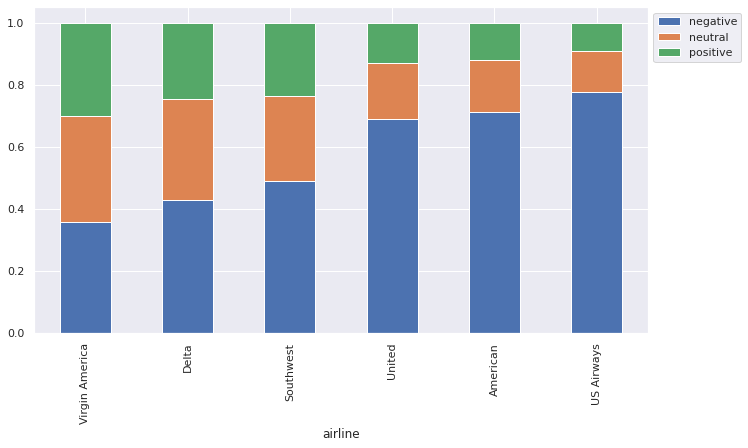

In [12]:
stacked_barplot(twt,'airline','airline_sentiment')

Few observations - 

1) US Airways, American and United have the highest percentage of negative 
tweets. Also, all these 3 airlines have highest number of tweets as well.

2) Vigin america has the highest percentage of positive tweets followed by Delta and southwest. Similar trend is shown with neutral tweets as well. 

3) US airways has the least percentage of positive tweets followed by American airlines.  

4) Virgin america's tweets are kind of equally divided into all 3 classes and has the least number of tweets compare to all the other airlines.

**Airline & Negativereason**

Plot negativereason behind negative tweets of each airlines and look how are they distributed.

negativereason  Bad Flight  Can't Tell  Cancelled Flight  \
airline                                                    
All                    580        1190               843   
United                 216         379               181   
Southwest               90         159               162   
American                87         198               242   
Delta                   64         186                51   
US Airways             104         246               189   
Virgin America          19          22                18   

negativereason  Customer Service Issue  Damaged Luggage  \
airline                                                   
All                               2904               74   
United                             681               22   
Southwest                          391               14   
American                           762               12   
Delta                              199               11   
US Airways                         811        

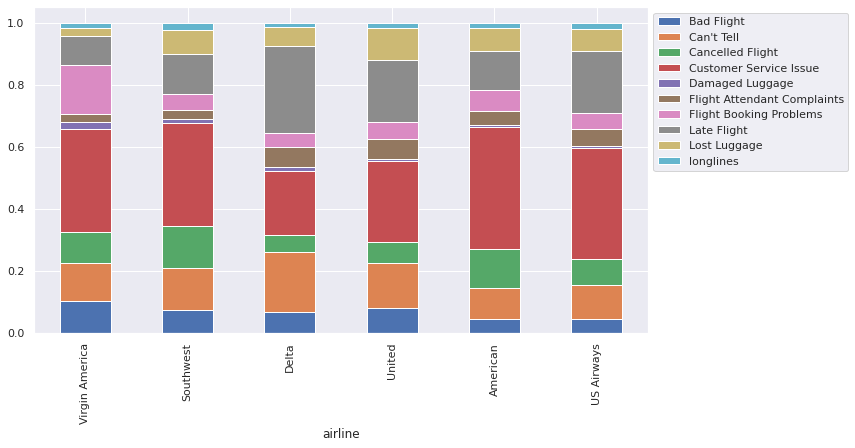

In [13]:
stacked_barplot(twt,'airline','negativereason')

Few observations - 

1) All the airlines have highest percentage of negative tweets are about 'customer service'. 

2) The most common reason behind Delta's has negative tweets is 'late flight'.

3) 'Flight attendent complaints' and 'flight booking problems' are the least reasons behind negative tweets. 

4) The reason for many negative tweets is 'cant tell'.

Let's create function to find counts/percentage of categorical columns like airline, negativereason etc. to understand them better.

In [14]:
# function to create labeled countplots

def labeled_countplot(data, feature, hue=None, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    if hue==None:
      ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
      )
    else: 
      ax = sns.countplot(
        data=data,
        x=feature,
        hue=hue,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
      )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

**Negativereason**

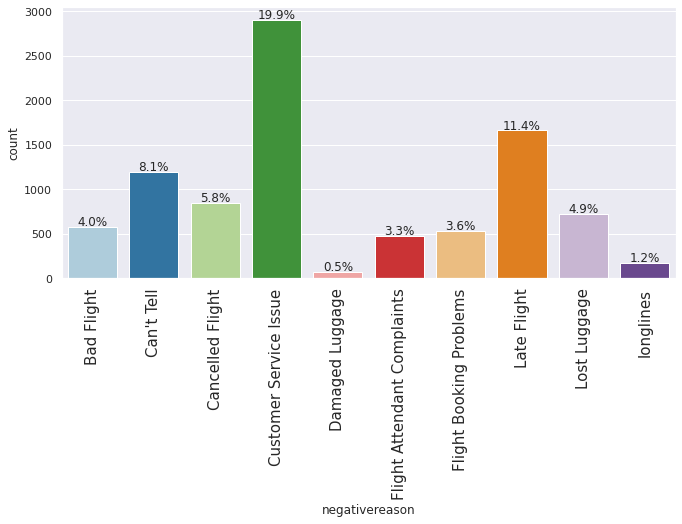

In [15]:
labeled_countplot(twt,'negativereason',perc=True, n=10)

Majority of negativereason is about customer service issue, followed by late flight and can't tell. Damaged luggage is the least negative reason. 

**Tweet_location**

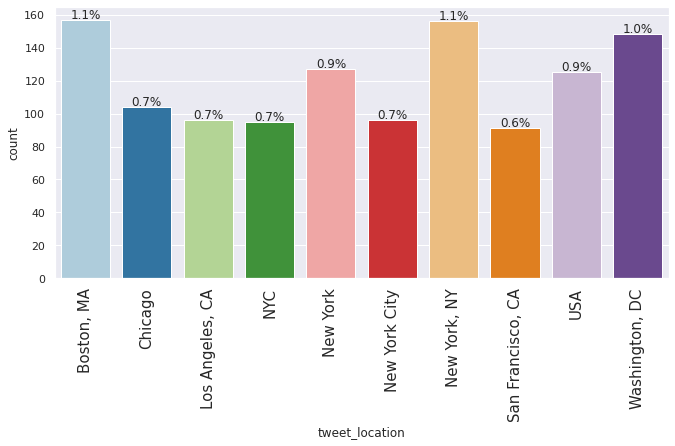

In [16]:
labeled_countplot(twt,'tweet_location',perc=True, n=10)

Majorty tweets were done from Boston, NYC and Washington DC. 

**Airline**

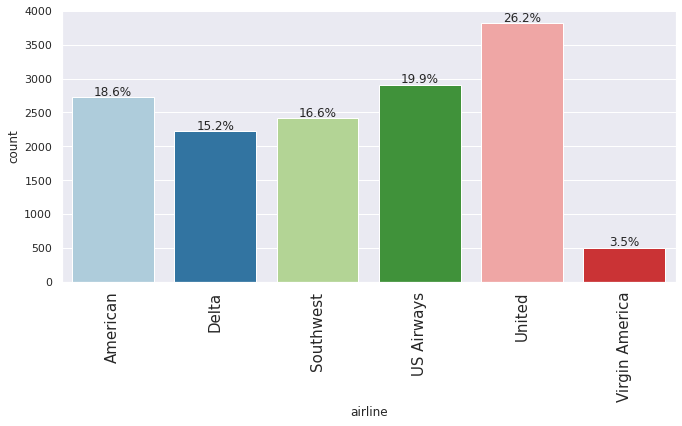

In [17]:
labeled_countplot(twt,'airline',perc=True, n=10)

Maximum tweets are about United followed by US airways and American. Virgin America has the least amount of tweets.  

**Airline_sentiment**

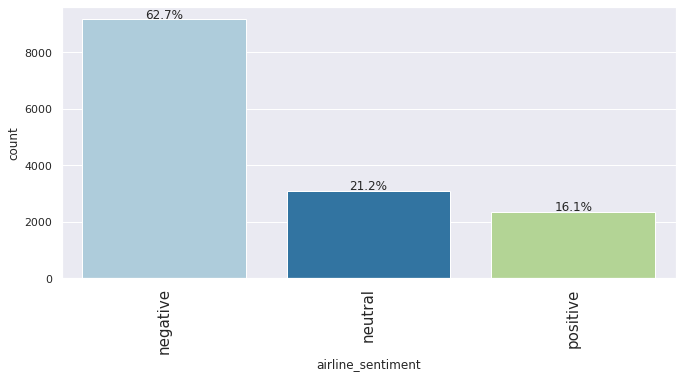

In [18]:
labeled_countplot(twt,'airline_sentiment',perc=True, n=10)

More than half, ~63% tweets have negative sentiment and positive sentiment is the least ~16%.

Let's create a function to plot sentiment by airlines.

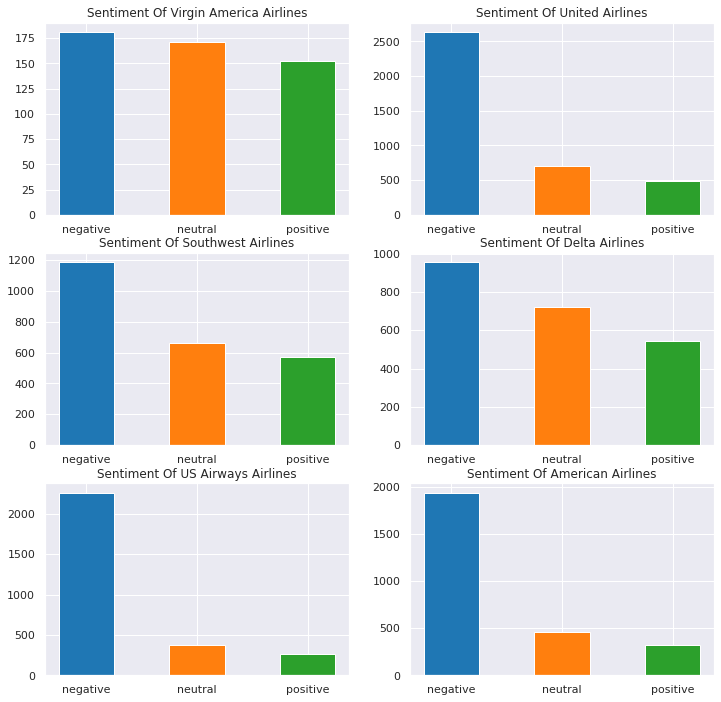

In [19]:
unique_airline_name = twt.airline.unique()
unique_sentiment = twt.airline_sentiment.unique()
# create function to plot sentiment by airline
def multi_labeled_count_plot(arln_name, col_nme, col_lst, title):
    arln = twt[twt.airline==arln_name]
    count = arln[col_nme].value_counts()
    set_index = range(1,(len(col_lst)+1))
    color=sns.color_palette("tab10")
    col_lst=list(col_lst)
    col_lst.sort()
    plt.bar(set_index,count,width=0.5,color=color)
    plt.xticks(set_index,col_lst)
    plt.title(title + arln_name + ' Airlines')


plt.figure(1,figsize=(12,12))

# looping over unique airline names to plot the graphs of sentiment
for i in range(len(unique_airline_name)):
    plt.subplot(3, 2, i+1)
    multi_labeled_count_plot(unique_airline_name[i], 'airline_sentiment', unique_sentiment,'Sentiment Of ')

Few observatons - 

1) all airlines have highest negative sentiments (as expected as seen before).

2) Delta has high count of neutral and positive tweets.

3) United and US airways has the least neutral and positive tweeets. 

Let's create different word clouds, one with all, one with negative sentiment, one with positive and one with neutral. Start with all. 

We will be using default stopwords remove them from the wordcloud.

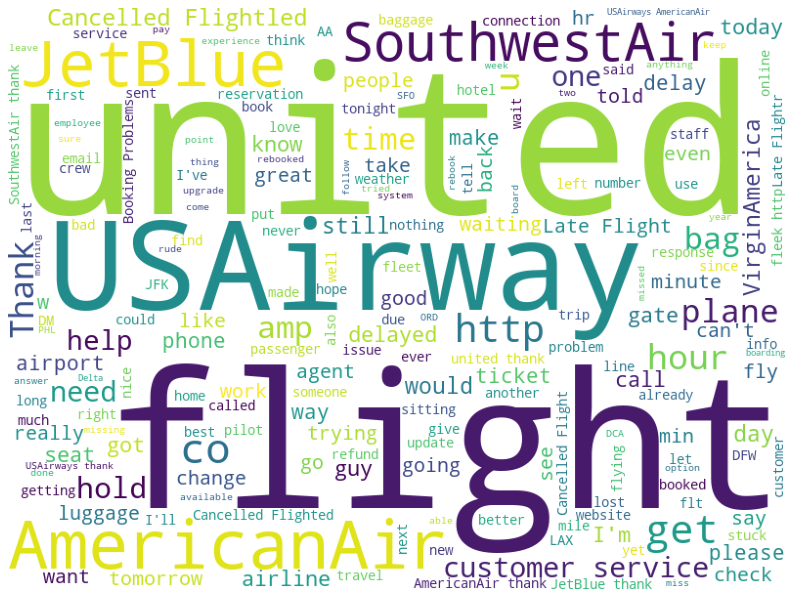

In [20]:
import wordcloud
#from nltk.corpus import stopwords
words = ' '.join(map(str,twt['text']))
new_text = " ".join(word for word in words.split())
stop_words = set(stopwords.words("english"))

wordcloud = wordcloud.WordCloud(stopwords=stop_words,
                      background_color='white',
                      colormap='viridis',
                      width=800,
                      height=600
                     ).generate(new_text)
plt.figure(1,figsize=(14, 11))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Looks like words like different airline names (united, americanair, jetblue etc.), http, flight, plane take majority of space. Let's remove those to see the other words and can understand more.

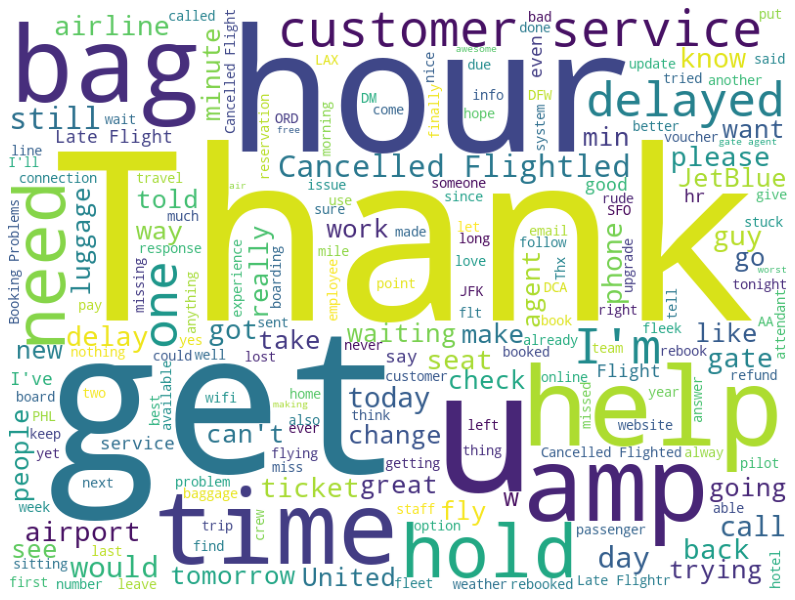

In [21]:
import wordcloud
#from nltk.corpus import stopwords
words = ' '.join(map(str,twt['text']))
clean_text = " ".join([word for word in words.split()
                            if 'http' not in word
                                and 'plane' not in word
                                and 'flight' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                                ])
stop_words = set(stopwords.words("english"))

clean_wordcloud = wordcloud.WordCloud(stopwords=stop_words,
                      background_color='white',
                      colormap='viridis',
                      width=800,
                      height=600
                     ).generate(clean_text)
plt.figure(1,figsize=(14, 11))
plt.imshow(clean_wordcloud)
plt.axis('off')
plt.show()

Thank, help, need, delayed, customer service are sentiment related words appear big so should be more mentioned in tweets. Other than Thank, most of all big words show negative sentiment (like cancelled flight, customer service, delayed etc.), which shows its imbalance dataset and we have seen that before too in this section.  

Also we can observe that the most frequent words choosen by people to express their sentiments.

Create word cloud of negative sentiments.

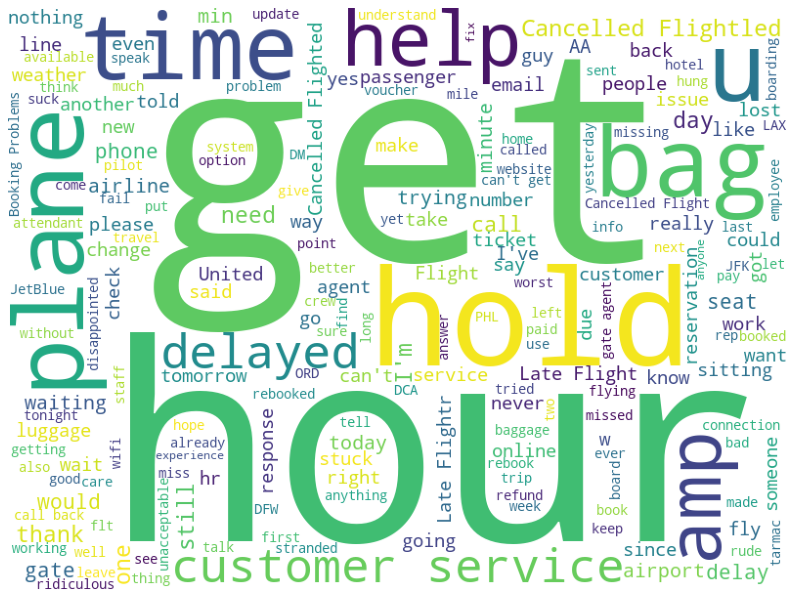

In [22]:
import wordcloud
#from nltk.corpus import stopwords

negative_text_df=twt[twt['airline_sentiment']=='negative']
neg_words = ' '.join(map(str,negative_text_df['text']))
neg_text = " ".join([word for word in neg_words.split()
                            if 'http' not in word
                                and 'flight' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
stop_words = set(stopwords.words("english"))

neg_wordcloud = wordcloud.WordCloud(stopwords=stop_words,
                      background_color='white',
                      colormap='viridis',
                      width=800,
                      height=600
                     ).generate(neg_text)
plt.figure(1,figsize=(14, 11))
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

People are showing their negative sentiment by using words like delayed, cancelled, customer service, help etc. frequently.

Create word cloud of positive sentiments.

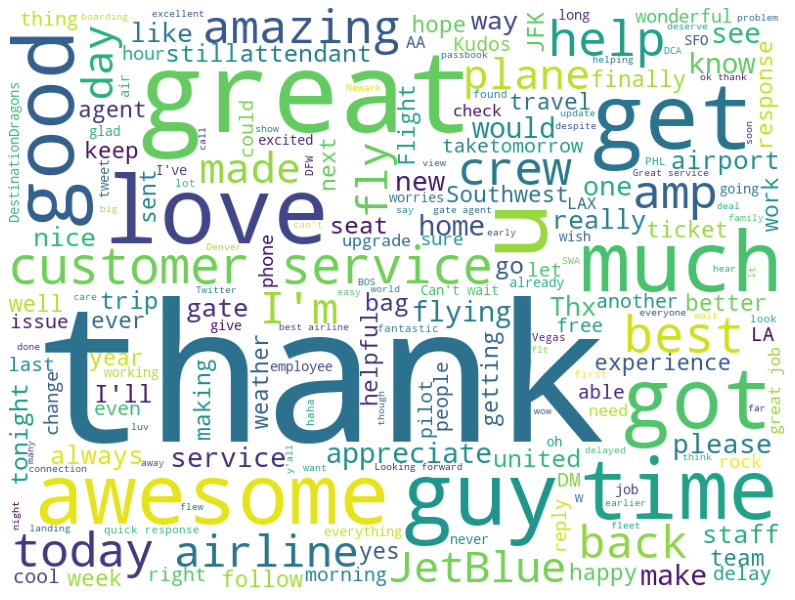

In [23]:
import wordcloud
#from nltk.corpus import stopwords

positive_text_df=twt[twt['airline_sentiment']=='positive']
pos_words = ' '.join(map(str,positive_text_df['text']))
pos_text = " ".join([word for word in pos_words.split()
                            if 'http' not in word
                                and 'flight' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
stop_words = set(stopwords.words("english"))

pos_wordcloud = wordcloud.WordCloud(stopwords=stop_words,
                      background_color='white',
                      colormap='viridis',
                      width=800,
                      height=600
                     ).generate(pos_text)
plt.figure(1,figsize=(14, 11))
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

People are showing their positive sentiment by using words like Thank, awesome, good, love, amazing etc. frequently.

Create word cloud of neutral sentiments.

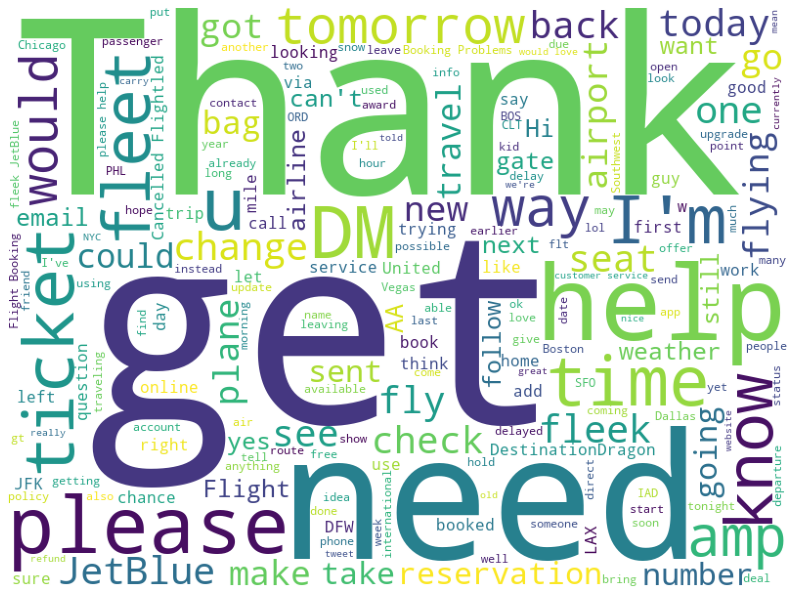

In [24]:
import wordcloud
#from nltk.corpus import stopwords

neutral_text_df=twt[twt['airline_sentiment']=='neutral']
neu_words = ' '.join(map(str,neutral_text_df['text']))
neu_text = " ".join([word for word in neu_words.split()
                            if 'http' not in word
                                and 'flight' not in word
                                and not word.startswith('@')
                                and word != 'RT'])
stop_words = set(stopwords.words("english"))

neu_wordcloud = wordcloud.WordCloud(stopwords=stop_words,
                      background_color='white',
                      colormap='viridis',
                      width=800,
                      height=600
                     ).generate(neu_text)
plt.figure(1,figsize=(14, 11))
plt.imshow(neu_wordcloud)
plt.axis('off')
plt.show()

People showing neutral sentiment by using words like Thank, need, get, help, please etc. frequently. We have seen some of these words used frequently in positive and negative sentiments word cloud also. This could be a problem while classifying them and have higher chances of misclassification. 

# **3. Data Pre-Processing**

Before the modeling, let's pre-process the data and make it suitable for modeling. To start with, let's drop non-required columns of dataset. 

## **Drop non-required columns**

Even though the dataset has many columns, for the purpose of modeling in this project, we really need 2 columns out of it. Text and airline_sentiment.

Let's keep only these 2 in the original dataset

In [11]:
twt=twt[['text','airline_sentiment']]

Check shape one time.

In [12]:
twt.shape

(14604, 2)

Check top 5 records.


In [13]:
twt.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


Looks good. We can now begin with pre-processing steps.

## **Text Pre-Processing**

As part of this section, I will be following below pre-processing steps. 

Remove html tags.

Replace contractions in string.

Remove numbers.

Remove airline user name

Tokenization.

Remove ascii characters.

Make it lowercase.

Remove special characters and punctuations. 

Remove Stopwords.

Lemmatized data.

We'll use the NLTK library to tokenize words, remove stopwords and lemmatize the remaining words.

To start with, I would remove HTML tags, expand the contraction, remove digits and remove airline name from the text that we know will not have impact on tweet analysis.

Create a function to remove HTML tags and apply it on the 'text' field of twt dataset. 

In [14]:
#remove the html tags
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")                    
    return soup.get_text()

# applying above function to the text column of the dataset
twt['text'] = twt['text'].apply(lambda x: strip_html(x))

Create a function to expland the contraction to replace I'm to I am etc. and apply it on the 'text' field of twt dataset.

In [15]:
#expand the contractions
def replace_contractions(text):
    """Replace contractions in string of text"""
    return contractions.fix(text)

# applying above function to the text column of the dataset
twt['text'] = twt['text'].apply(lambda x: replace_contractions(x))

Create a function to remove numbers from the text and apply it on the 'text' field of twt dataset.

In [16]:
#remove the numericals present in the text
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

# applying above function to the text column of the dataset
twt['text'] = twt['text'].apply(lambda x: remove_numbers(x))


Create a function to remove airline names. All the airline names are users and they are addressed with '@' - so will create a function that removes all words start with '@' and apply it on the 'text' field of twt dataset.

In [17]:
# Remove @username
def remove_airline_name(text):
  text = re.sub('@[^\s]+','',text)
  return text

# applying above function to the text column of the dataset
twt['text'] = twt['text'].apply(lambda x: remove_airline_name(x))

Let's check few sample records after running above pre-processing steps

In [18]:
# checking few sample records
twt.sample(10)

,text,airline_sentiment
4186,plus you horrible seating and poor customer s...,negative
10568,if one with why cannot you use American mile...,negative
7082,which type plane is flt from bos to rsw?,neutral
9727,- just passed the hour mark #onholdwith you ...,negative
6668,Thanks. Yes I got through. Biggest frustratio...,negative
3530,"KOA-LAX should have fresh food service, right?",neutral
13161,you said this last time. It does not take we...,negative
10426,FINALLY leaving home from NC. Will lodge res...,negative
2398,yes Cancelled Flightled. Moved to . I will f...,negative
8773,"yes, well they are operating outside of your ...",negative


Before we apply more pre-processing steps to the text, let's tokenize the data.  

In [19]:
# Tokenization of data
twt['text'] = twt.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) 
# check top 5 records
twt.head()

,text,airline_sentiment
0,"[What, said, .]",neutral
1,"[plus, you, have, added, commercials, to, the,...",positive
2,"[I, did, not, today, ..., Must, mean, I, need,...",neutral
3,"[it, is, really, aggressive, to, blast, obnoxi...",negative
4,"[and, it, is, a, really, big, bad, thing, abou...",negative


Looks good. Now, I will continue with rest of the text pre-processing steps.

Create a function to remove ascii characters from the tokenised list. The new list of words would be added in a new list.

In [20]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

Create a function to make all words as lowercase from the tokenised list. The new list of words would be added in a new list.

In [21]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

Create a function to remove punctuation from the tokenised list. The new list of words would be added in a new list.

In [22]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

Create a function to remove stop words from the tokenised list. For that, first will start with the default list of stopwords library. After that, will delete soem words that matters in sentiment from that list. And at last, will add some words like flight, plane that we saw earlier are heavily used and not required. The final list after the removing stopwords will be stored as new list.

In [23]:
#from nltk.corpus import stopwords  
stop_words = stopwords.words('english')

customlist = ['not', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn',
        "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',
        "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
        "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

# Set custom stop-word's list as not, couldn't etc. words matter in Sentiment, so not removing them from original data.

stop_words = list(set(stop_words) - set(customlist))  
stop_words.append(['flight','plane','RT'])

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

Create a function to lemantize words from the tokenised list. The new list of words would be added in a new list.

In [24]:
nltk.download('omw-1.4')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


Let's create another function to call all above functions in an order and then join the words of the list to make it like original

In [25]:
def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

twt['text'] = twt.apply(lambda row: normalize(row['text']), axis=1)


Print top 5 rows of final dataset

In [26]:
twt.head()

,text,airline_sentiment
0,say,neutral
1,plus add commercials experience tacky,positive
2,not today must mean need take another trip,neutral
3,really aggressive blast obnoxious entertainmen...,negative
4,really big bad thing,negative


Data looks good. 

# **4. Vectorization**

In this section, will be using two methods of vectorization. CountVectorizer and TF-IDF (Term Frequency times Inverse Document Frequency).


While constructing a dictionary that contains the set of all unique words from text tweets dataset, so that could be huge and can lot of processing time. I am going to limit the unique words to 2000 to limit the processing time. 

**CountVectorizer**

Create dataset by converting text to numbers so can be used in modeling using CountVectorizer. 
.

In [27]:
# Vectorization (Convert text data to numbers).
from sklearn.feature_extraction.text import CountVectorizer

Count_vec = CountVectorizer(max_features=2000)                # Keep only 2000 features as number of features will increase the processing time.
data_features_cntvct = Count_vec.fit_transform(twt['text'])

data_features_cntvct = data_features_cntvct.toarray()       

Let's check the shape of new dataset. 

In [28]:
data_features_cntvct.shape       #Shape of the feature vector

(14604, 2000)

Looks as expected. 

**TF-IDF**

Create dataset by converting text to numbers so can be used in modeling using TFidfVectorizer. 

In [29]:
# Using TfidfVectorizer to convert text data to numbers.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=2000)  # Keep only 2000 features as number of features will increase the processing time.
data_features_tfidf = tfidf_vect.fit_transform(twt['text'])

data_features_tfidf = data_features_tfidf.toarray()



Let's check the shape of new dataset. 

In [30]:
#feature shape
data_features_tfidf.shape     

(14604, 2000)

Looks as expected. 

# **5. Model Building**

In this section, I will be using datasets created by count and tf-idf vectorizers to do the modeling and compare the results. 

## **Using CountVectorizer**

First, I will use dataset created using CountVectorizer. Going to use randomforest for modeling. Let's assign the values to X (dataset) and y (target) and split them in train and test. As going to use randomforest, target variable doesn't need to be converted to numeric. I can keep the original values.  

In [33]:
X = data_features_cntvct # assigning the dataset created using count vectorizer

y = twt.airline_sentiment

In [34]:
# Split data into training and testing set. Splitting with 30% for test and 70% for training.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# print the shape of train and test
print(X_train.shape, X_test.shape)

(10222, 2000) (4382, 2000)


In [35]:
# Checking class balance for whole data, train set and test set

print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y
negative    0.627157
neutral     0.211654
positive    0.161189
Name: airline_sentiment, dtype: float64
********************************************************************************
Target value ratio in y_train
negative    0.627177
neutral     0.211602
positive    0.161221
Name: airline_sentiment, dtype: float64
********************************************************************************
Target value ratio in y_test
negative    0.627111
neutral     0.211775
positive    0.161114
Name: airline_sentiment, dtype: float64
********************************************************************************


Looks good. Let's build the model using RandomForest classifier. 

In [36]:
# Using Random Forest to build model for the classification of tweets.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, X, y, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7430853796892727


Cross val score is around 74%, which is ok but not that good. Over here, we just used estimators randomly. Next, lets find the optimal number by looping over 1 to 25 and use that to see if we can improve the score. 

In [37]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]
base_ln

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

Apply each value of base_ln to RandomForest and calculate the score. 

In [38]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

Plot the errors on graph to find the optimal number.

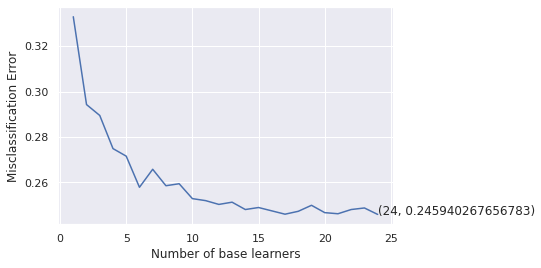

In [39]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

It is around 24, use that to fit the model on RandomForest classifier and get the score on test data.

In [40]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7549064354176175

Score is around 75.5%, which is ok, but will try do better. 

Let's save the predicted values in results to plot confusion matrix.

In [41]:
result_cntvct =  clf.predict(X_test)    

[[2429  223   96]
 [ 379  459   90]
 [ 176  110  420]]
0.7549064354176175


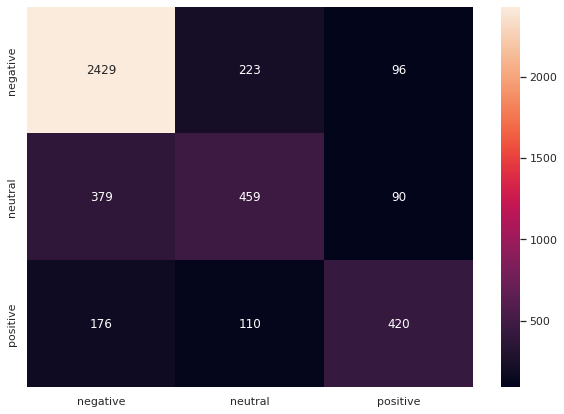

In [48]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result_cntvct)

print(conf_mat)

print(metrics.f1_score(y_test, result_cntvct,average='micro'))

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral','positive']],
                  columns = [i for i in ['negative','neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

All 3 classes were identified correctly for many records. Misclassification between Negative and Neutral was maximum and it could be due to the frequent common words between these 2 classes (as shee in word cloud during EDA). 

Let's find what the top 40 features using count vectorizer and plot them into the word cloud.

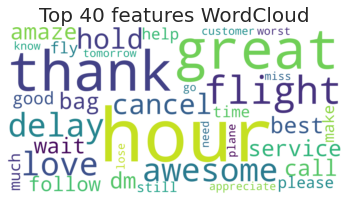

In [64]:
all_features = Count_vec.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '
    
    

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

Top features include, thank, hour, great, love, delay etc. 

## **Using TF-IDF**

For this section, I will use dataset which was created using TF-IDF vectorizer.

TF-IDF gives less importance to the most frequent words and it also considers less frequent words. So I am hoping to get better performance than count vectorizer.

Over here also, going to use randomforest for modeling. Let's assign the values to X (dataset) and y (target) and split them in train and test. As going to use randomforest, target variable doesn't need to be converted to numeric. I can keep the original values.

In [50]:
X = data_features_tfidf # assigning the dataset created using tf-idf vectorizer

y = twt.airline_sentiment

In [51]:
# Split data into training and testing set. Splitting with 30% for test and 70% for training.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# printing the shape of train and test
print(X_train.shape, X_test.shape)

(10222, 2000) (4382, 2000)


In [52]:
# Checking class balance for whole data, train set and test set

print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y
negative    0.627157
neutral     0.211654
positive    0.161189
Name: airline_sentiment, dtype: float64
********************************************************************************
Target value ratio in y_train
negative    0.627177
neutral     0.211602
positive    0.161221
Name: airline_sentiment, dtype: float64
********************************************************************************
Target value ratio in y_test
negative    0.627111
neutral     0.211775
positive    0.161114
Name: airline_sentiment, dtype: float64
********************************************************************************


Looks good. Let's build the model using RandomForest classifier.

In [53]:
# Using Random Forest to build model for the classification of reviews.
# Also calculating the cross validation score.

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

forest = RandomForestClassifier(n_estimators=10, n_jobs=4)

forest = forest.fit(X_train, y_train)

print(forest)

print(np.mean(cross_val_score(forest, X, y, cv=10)))

RandomForestClassifier(n_estimators=10, n_jobs=4)
0.7434959635453293


Cross val score is around 74.3%, which is not great. Over here, we just used estimators randomly. Next, lets find the optimal number by looping over 1 to 25 and use that to see if we can improve the score.

In [54]:
# Finding optimal number of base learners using k-fold CV ->
base_ln = [x for x in range(1, 25)]
base_ln

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

Apply each value of base_ln to RandomForest and calculate the score.

In [55]:
# K-Fold Cross - validation .
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train, y_train, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

Plot the errors on graph to find the optimal number.

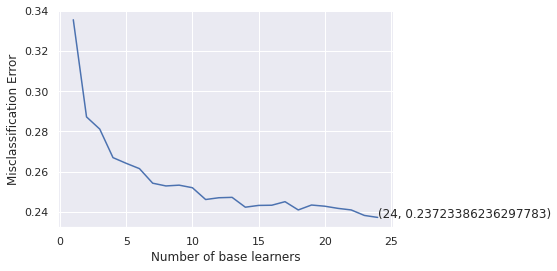

In [56]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

It is around 24, use that to fit the RandomForest classifier and get the score on test data.

In [57]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.7608397991784573

Score is around 76%, which is slightly better than what we saw on count vectorizer.

Let's save the predicted values in results to plot confusion matrix.

In [58]:
result_tfidf =  clf.predict(X_test)                  #saving the prediction on test data as a result

[[2514  167   67]
 [ 408  443   77]
 [ 226  103  377]]
0.7608397991784573


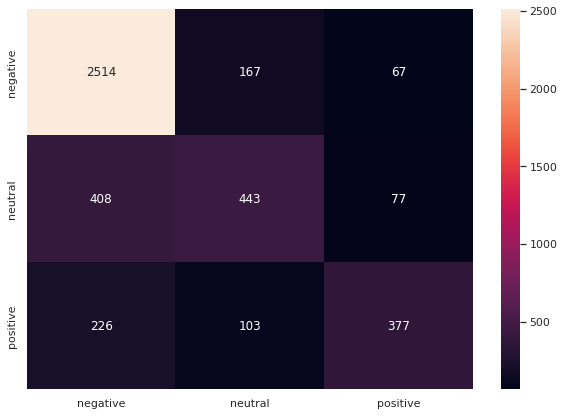

In [59]:
# Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, result_tfidf)

print(conf_mat)

print(metrics.f1_score(y_test, result_tfidf,average='micro'))

df_cm = pd.DataFrame(conf_mat, index = [i for i in ['negative','neutral','positive']],
                  columns = [i for i in ['negative','neutral','positive']])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')

All 3 classes were identified correctly for many records. It is little more than Countvectorizer model. Misclassification between Negative and Neutral was maximum, bit lower than countvectorizer. 

Let's find what the top 40 features using count vectorizer and plot them into the word cloud.

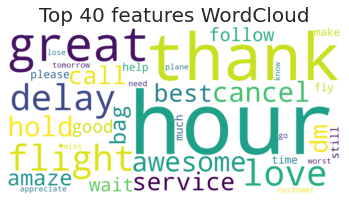

In [65]:
all_features = tfidf_vect.get_feature_names()              #Instantiate the feature from the vectorizer
top_features=''                                            # Addition of top 40 feature into top_feature after training the model
feat=clf.feature_importances_
features=np.argsort(feat)[::-1]
for i in features[0:40]:
    top_features+=all_features[i]
    top_features+=' '
    
    

from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

Top features include hour, thank, delay, great etc.


## **Comparing the accuracies of Count Vectorizer and TF-IDF**

Let's check few test samples of both count vectorizer and TF-IDF and see. 

In [61]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = result_cntvct
df['tf_idf_predicted'] = result_tfidf
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted
0,negative,negative,negative
1,neutral,negative,negative
2,neutral,neutral,negative
3,negative,negative,negative
4,negative,negative,negative


They predicted almost same in sample records. In one of the instances, when original was neutral, count vector predicted as neutral and tf-idf as negative. Let's compare and plot their accuracy score. 

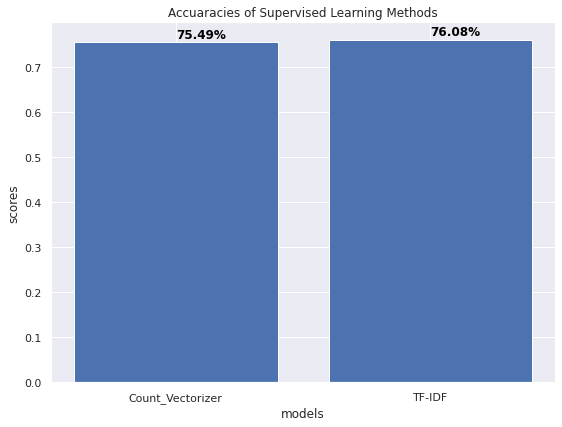

In [62]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['Count_Vectorizer', 'TF-IDF']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test,result_cntvct),accuracy_score(y_test,result_tfidf)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies of Supervised Learning Methods')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    plt.savefig('barplot_1.png',dpi=100, format='png', bbox_inches='tight')
plt.show()

Both performed very close. TF-IDF is litter better over count vectorizer, which is as expected. 

The desired accuracy is supposed to be above 75% and we achieved that already. However, I would still like to try different other methods in the next section to see if we can make it better than this.

# **6. Trying Few More Modeling Techniques**

So far, we checked RandomForest with CountVectorizer and TF-IDF. There are few more classification modeling techniques we can try. Also, we can try sampling menthods (over and under) and see how it affect the scores. I will try few of them using TF-IDF only as it was slightly better than count vectorizer. 

For different modeling techniques, will try classifiers like DecisionTree, Bagging, GradientBoosting, Adaboost and XGBoost with their basic default parameters to get an idea how they perform. And later in the section, will try undersampling and oversampling on the model with best scores.     

First, let's import libraries that would require to check out different models.

In [44]:
# to split the data into train and test
from sklearn.model_selection import train_test_split

# To get model classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics

from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


# To undersample and un the data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# to create k folds of data and get cross validation score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score

# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

As mentioned earlier, will user dataset created by tf-idf earlier.

In [45]:
X = data_features_tfidf

y = twt.airline_sentiment

Let's convert the classes into numeric values as not all model will accept string. I will call negative as 0, neutral as 1 and positive as 2. 

In [46]:
# convert Sentiments to 0,1,2
def num_airline_sentiment(senti):
    if  senti == "negative":
        return 0
    elif senti == "neutral":
        return 1
    elif senti == "positive":
        return 2

# Apply convert_Sentiment function
y = y.apply(lambda x : num_airline_sentiment(x))

Check different values of y

In [47]:
y.value_counts()

0    9159
1    3091
2    2354
Name: airline_sentiment, dtype: int64

Looks good.

In [48]:
# Split data into training and testing set.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# print the shape of train and test
print(X_train.shape, X_test.shape)

(10222, 2000) (4382, 2000)


Looks good. Next, check the division of all 3 classes into train, test and original.

In [49]:
# Checking class balance for whole data, train set, validation set, and test set

print("Target value ratio in y")
print(y.value_counts(1))
print("*" * 80)
print("Target value ratio in y_train")
print(y_train.value_counts(1))
print("*" * 80)
print("Target value ratio in y_test")
print(y_test.value_counts(1))
print("*" * 80)

Target value ratio in y
0    0.627157
1    0.211654
2    0.161189
Name: airline_sentiment, dtype: float64
********************************************************************************
Target value ratio in y_train
0    0.627177
1    0.211602
2    0.161221
Name: airline_sentiment, dtype: float64
********************************************************************************
Target value ratio in y_test
0    0.627111
1    0.211775
2    0.161114
Name: airline_sentiment, dtype: float64
********************************************************************************


Looks good, its very close.

##**Multiple Models With Different Classifiers**

In [42]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("DecisionTree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random_forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))


results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Performance:" "\n")

for name, model in models:
    scoring = "accuracy"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

print("\n" "Training Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = accuracy_score(y_train, model.predict(X_train)) * 100
    print("{}: {}".format(name, scores))


Cross-Validation Performance:

DecisionTree: 69.51680151579673
Bagging: 74.1440102584223
Random_forest: 76.48211235460455
GBM: 73.74289829137938
Adaboost: 72.39292054028968

Training Performance:

DecisionTree: 99.09019761299159
Bagging: 96.93797691254159
Random_forest: 99.09019761299159
GBM: 76.24730972412443
Adaboost: 73.37116024261398


RandomForest performed the best in Cross-validation and training. Let's check the performance of these models on test. 

In [43]:
# check on testing data
for name, model in models:
  print(f"Testing performance of {name}\n",model.score(X_test, y_test))

Testing performance of DecisionTree
 0.7081241442263807
Testing performance of Bagging
 0.7480602464628023
Testing performance of Random_forest
 0.7672295755362848
Testing performance of GBM
 0.7366499315381104
Testing performance of Adaboost
 0.7186216339570972


RandomForest performed the best over here as well with 76.7%. 

**XGBoost Classifier**

Let's try one more classifier, XGBoost.

In [86]:
# creating and fitting xgb model
xgb = XGBClassifier(random_state=1,eval_metric='logloss')
xgb.fit(X_train,y_train)

XGBClassifier(eval_metric='logloss', objective='multi:softprob', random_state=1)

Check the score on training data.

In [87]:
xgb.score(X_train, y_train)


0.7419291723733125

Check the score on testing data.

In [88]:
xgb.score(X_test, y_test)

0.727293473299863

XGBoost also didn't perform as well as RandomForest. 

## **Modeling Using Undersampled & Oversampled Data**

As we have seen, RandomForest performed the best so will use that for this section. 

I would like to try undersampling & oversampling methods and use RandomForest with basic parameters that we used earlier and see if we can better score compare to when it was done using same parameters. If we get, I can get into deeper. Again, I will use the train and test data that was built on TF-IDF dataset.   

**Undersampling**

In [51]:
# fit random under sampler on the train data
rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

Check the count after the undersampling and compare with previous. 

In [54]:
# check the data
print("Before Undersampling, counts of Negative Sentiments: {}".format(sum(y_train == 0)))
print("Before Undersampling, counts of Neutral Sentiments: {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of Positive Sentiments: {} \n".format(sum(y_train == 2)))

print("After Undersampling, counts of Negative Sentiments: {}".format(sum(y_train_un == 0)))
print("After Undersampling, counts of Neutral Sentiments: {}".format(sum(y_train_un == 1)))
print("After Undersampling, counts of Positive Sentiments: {} \n".format(sum(y_train_un == 2)))

print("After Undersampling, the shape of train_X: {}".format(X_train_un.shape))
print("After Undersampling, the shape of train_y: {} \n".format(y_train_un.shape))

Before Undersampling, counts of Negative Sentiments: 6411
Before Undersampling, counts of Neutral Sentiments: 2163
Before Undersampling, counts of Positive Sentiments: 1648 

After Undersampling, counts of Negative Sentiments: 1648
After Undersampling, counts of Neutral Sentiments: 1648
After Undersampling, counts of Positive Sentiments: 1648 

After Undersampling, the shape of train_X: (4944, 2000)
After Undersampling, the shape of train_y: (4944,) 



Looks good. All classes have the same count of 1648.

In [59]:
# Create and fit the RF model on undersampled data and calculate the score on test data .
un_rf = RandomForestClassifier(n_estimators=10, n_jobs=4)
un_rf.fit(X_train_un, y_train_un)
un_rf.score(X_test, y_test)

0.6976266544956641

Score is 69%, lesser than what we saw with same parameters on original data (74%). I do not think I will move forward with undersampled data anymore.  

**Oversampling**

Using SMOTE to do oversampling and checking counts to make sure it worked fine. 

In [62]:
# applying smote
print("Before Oversampling, counts of Negative Sentiments: {}".format(sum(y_train == 0)))
print("Before Oversampling, counts of Neutral Sentiments: {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of Positive Sentiments: {} \n".format(sum(y_train == 2)))

sm = SMOTE(
    k_neighbors=5, random_state=1
)  # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After Oversampling, counts of Negative Sentiments: {}".format(sum(y_train_over == 0)))
print("After Oversampling, counts of Neutral Sentiments: {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of Positive Sentiments: {} \n".format(sum(y_train_over == 2)))


print("After Oversampling, the shape of train_X: {}".format(X_train_over.shape))
print("After Oversampling, the shape of train_y: {} \n".format(y_train_over.shape))

Before Oversampling, counts of Negative Sentiments: 6411
Before Oversampling, counts of Neutral Sentiments: 2163
Before Oversampling, counts of Positive Sentiments: 1648 

After Oversampling, counts of Negative Sentiments: 6411
After Oversampling, counts of Neutral Sentiments: 6411
After Oversampling, counts of Positive Sentiments: 6411 

After Oversampling, the shape of train_X: (19233, 2000)
After Oversampling, the shape of train_y: (19233,) 



Looks good. Each class will have 6411 records now and total train dataset has 19,233 records.  

In [61]:
# Create and fit the RF model on undersampled data and calculate the score on test data .
over_rf = RandomForestClassifier(n_estimators=10, n_jobs=4)
over_rf.fit(X_train_over, y_train_over)
over_rf.score(X_test, y_test)

0.7361935189411227

Score is 73.6%, lesser than what we saw with same parameters on original data (74%). I do not think I will move forward with oversampled data anymore either.

After trying various methods in this section, I have decided to consider what we have seen best in section 5 - RandomForest on TF-IDF dataset by finding best optimial parameter with the score of 76%.

## **7. Unsupervised Learning Methods**

We tried all different kinds of supervised methods in previous sections. Let's try unsupervised learning methods like TextBlob and VADER and see if we can improve the accuracy score.

## **TextBlob**

Import required library

In [4]:
from textblob import TextBlob

First make a copy called data_new from twt.

In [44]:
 #make a copy of dataframe and do unsupervised operations on that dataframe
data_new = twt.copy()     

Create a new column for polarity in a new dataframe.

In [45]:
#Calculate the polarity score of the reviews
data_new['polarity']  = data_new['text'].apply(lambda review: TextBlob(review).sentiment.polarity)

# checking first few records. 
data_new.head()

,text,airline_sentiment,polarity
0,say,neutral,0.00000
1,plus add commercials experience tacky,positive,0.00000
2,not today must mean need take another trip,neutral,-0.31250
3,really aggressive blast obnoxious entertainmen...,negative,0.00625
4,really big bad thing,negative,-0.35000


Set the threshold on polarity score. 

In [46]:
#Classify the class of the review by keeping threshold on the polarity score
data_new['polarity_score'] = data_new['polarity'].apply(lambda c: '1' if c >=0 else '0')

# checking first few records. 
data_new.head()

,text,airline_sentiment,polarity,polarity_score
0,say,neutral,0.00000,1
1,plus add commercials experience tacky,positive,0.00000,1
2,not today must mean need take another trip,neutral,-0.31250,0
3,really aggressive blast obnoxious entertainmen...,negative,0.00625,1
4,really big bad thing,negative,-0.35000,0


Add the polarity score column to original dataset. 

In [47]:
twt["Text_Blob_pred"] = data_new['polarity_score'].tolist()

# checking first few records 
twt.head()

,text,airline_sentiment,Text_Blob_pred
0,say,neutral,1
1,plus add commercials experience tacky,positive,1
2,not today must mean need take another trip,neutral,0
3,really aggressive blast obnoxious entertainmen...,negative,1
4,really big bad thing,negative,0


Convert airline sentiment values to numeric. 

In [48]:
# convert Sentiments to 0,1,2
def num_airline_sentiment(senti):
    if  senti == "negative":
        return 0
    elif senti == "neutral":
        return 1
    elif senti == "positive":
        return 2

# Apply convert_Sentiment function
twt['airline_sentiment'] = twt['airline_sentiment'].apply(lambda x : num_airline_sentiment(x))

Calcluate the accuracy

In [49]:
#Calculate the accuracy of the Vader Sentiment Analysis
twt["airline_sentiment"] = twt["airline_sentiment"].astype(int)  #convert the sentiment column values into int data type
twt["Text_Blob_pred"] = twt["Text_Blob_pred"].astype(int)  #convert the textblob predicted column values into int data type
print("Accuaracy of using Text Blob Sentiment Analysis is : ",
      accuracy_score(twt["airline_sentiment"].tolist(),twt["Text_Blob_pred"].tolist()))

Accuaracy of using Text Blob Sentiment Analysis is :  0.3903005464480874


It is only 39% which is very low compare to what we saw before. I will stop here and not do further checks. 

## **VADER**

Import required libraries and initialize SentimentIntensityAnalyzer.

In [17]:
import nltk
#download vader lexicon
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer 

sentiment = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


First make a copy called data_new from twt.

In [50]:
#make a copy of dataframe and do unsupervised operations on that dataframe
data_new = twt.copy()   

Calculate the score for each record.

In [51]:
#Calculate the polarity score of the reviews
data_new['scores'] = data_new['text'].apply(lambda review: sentiment.polarity_scores(review))

# checking first few records 
data_new.head()

,text,airline_sentiment,Text_Blob_pred,scores
0,say,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,plus add commercials experience tacky,2,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,not today must mean need take another trip,1,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,really aggressive blast obnoxious entertainmen...,0,1,"{'neg': 0.369, 'neu': 0.43, 'pos': 0.201, 'com..."
4,really big bad thing,0,0,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp..."


Out of all negative, neutral, positive and compound scores, add compound to the dataset as separate column.

In [52]:
#Calculate the compund score of the reviews
data_new['compound']  = data_new['scores'].apply(lambda score_dict: score_dict['compound'])

# checking first few records 
data_new.head()

,text,airline_sentiment,Text_Blob_pred,scores,compound
0,say,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
1,plus add commercials experience tacky,2,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,not today must mean need take another trip,1,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
3,really aggressive blast obnoxious entertainmen...,0,1,"{'neg': 0.369, 'neu': 0.43, 'pos': 0.201, 'com...",-0.3306
4,really big bad thing,0,0,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp...",-0.5829


Set the threshold for compound score.

In [53]:
#Classify the class of the review by keeping threshold on the compund score
data_new['comp_score'] = data_new['compound'].apply(lambda c: '1' if c >=0 else '0')

# checking first few records 
data_new.head()

,text,airline_sentiment,Text_Blob_pred,scores,compound,comp_score
0,say,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
1,plus add commercials experience tacky,2,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
2,not today must mean need take another trip,1,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
3,really aggressive blast obnoxious entertainmen...,0,1,"{'neg': 0.369, 'neu': 0.43, 'pos': 0.201, 'com...",-0.3306,0
4,really big bad thing,0,0,"{'neg': 0.557, 'neu': 0.443, 'pos': 0.0, 'comp...",-0.5829,0


Add a new column in twt dataframe with compound score (with threshold set).

In [54]:
twt["VADER_pred"] = data_new['comp_score'].tolist()

# checking first few records 
twt.head()

,text,airline_sentiment,Text_Blob_pred,VADER_pred
0,say,1,1,1
1,plus add commercials experience tacky,2,1,1
2,not today must mean need take another trip,1,0,1
3,really aggressive blast obnoxious entertainmen...,0,1,0
4,really big bad thing,0,0,0


Calculate the accuracy.

In [55]:
#Calculate the accuracy of the Vader Sentiment Analysis
twt["airline_sentiment"] = twt["airline_sentiment"].astype(int)   #convert the sentiment column values into int data type
twt["VADER_pred"] = twt["VADER_pred"].astype(int) #convert the vader_predicted column values into int data type
print("Accuaracy using Vader Sentiment Analysis is : ",
      accuracy_score(twt["airline_sentiment"].tolist(),twt["VADER_pred"].tolist()))

Accuaracy using Vader Sentiment Analysis is :  0.47602459016393445


It got the accuracy score of around 48%, better than TextBlob but not close to what we earlier. I would not like to do any further steps. 

# **8. Conclusion**

As part of this project, we have analyzed the dataset containing tweets from twitter about different US airlines. The objective was to do sentiment analysis of those tweets and create model that can predict the sentiment of tweets and put into one of the three categories (negative, neutral & positive). 

To achieve the goal, we followed below steps.  

*   After loading and exploring data at high leve, did EDA on the dataset to understand it better. Also, created word cloud for whole data and one for each classification. 

*   After dropping all non-required columns, performed various pre-processing on the text column which contains tweets info. Text column became clean.

*   Applied vectorization methods like CountVectorizer and TF-IDF on the cleaned text column to convert text to number and so make it suitable for the model

*   For modeling, started with RandomForest on both (countvectorizer and tf-idf) datasets and optimized the parameter, which increased the accuracy by bit. After the model was ready, applied test data on it and got decent results.

*   We also tried different other classification models and techniques like oversampling and undersampling to check if we get better accuracy than RandomForest, but we didn't get any. 

* Further, we tried with unsupervised techniques like VADER and TextBlob but the accuracy was very poor with both of them.


*   The best accuracy we found on test data was 76% which as on RandomForest iwth optimized parameter and on TF-IDF dataset. 

Even though we got decent accuracy on test data, few suggestions to improve it further -

* To start with, we can add more data to it. Tweeter has lot of data and we worked with only 14K records, we can try to scrap more data and try it out. 

*  We limited the features at 2000, we can try to add more and see if that helps. It would take more time and processing but still can try.  Also, we can try different pre-processing techniques like lemmatization using stacy.

*   We can try other modeling techniques like stacking classifier and also to hyperparameter turning to the models we tried and see if it makes it better.    



